In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gum.about()
gnb.configuration()


pyAgrum version 0.12.0.9
(c) Pierre-Henri Wuillemin, Christophe Gonzales, Lionel Torti
    UPMC 2015

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,posix [linux]
Python,"3.6.3 (default, Oct 3 2017, 21:45:48) [GCC 7.2.0]"
IPython,6.3.1
MatPlotLib,2.2.2
Numpy,1.14.3
pyAgrum,0.12.0.9


# Generating the database from a BN

In [3]:
bn=gum.loadBN(os.path.join("res","asia.bif"))
bn

(gum::BayesNet<double>@0x3410f30) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [4]:
gum.generateCSV(bn,os.path.join("out","sample_asia.csv"),500000,True)

 out/sample_asia.csv : [ ##################################################### ] 100%
Log2-Likelihood : -1612529.7441354685


-1612529.7441354685

In [5]:
import pyAgrum.lib._utils.oslike as oslike
print("===\n  Size of the generated database\n===")
oslike.wc_l(os.path.join("out","sample_asia.csv"))
print("\n===\n  First lines\n===")
oslike.head(os.path.join("out","sample_asia.csv"))

===
  Size of the generated database
===
500000

===
  First lines
===
tuberculosis?,bronchitis?,tuberculos_or_cancer?,visit_to_Asia?,positive_XraY?,smoking?,lung_cancer?,dyspnoea?
1,1,1,1,1,0,1,1
1,1,1,1,0,1,1,1
1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,0
1,1,1,1,1,0,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1
1,0,1,1,1,1,1,0



In [6]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.names()

('tuberculosis?',
 'bronchitis?',
 'tuberculos_or_cancer?',
 'visit_to_Asia?',
 'positive_XraY?',
 'smoking?',
 'lung_cancer?',
 'dyspnoea?')

In [7]:
learner.idFromName('visit_to_Asia?') # first row is 0

3

In [8]:
learner.nameFromId(4)

'positive_XraY?'

The BNLearner is capable of recognizing missing values in databases. For this purpose, just indicate as a last argument the list of the strings that represent missing values. Note that, currently, the BNLearner is not yet able to learn in the presence of missing values. This is the reason why, when it discovers that there exist such values, it raises a gum.MissingValueInDatabase exception.

In [9]:
# it is possible to add as a last argument a list of the symbols that represent missing values:
# whenever a cell of the database is equal to one of these strings, it is considered as a 
# missing value
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn, ['?', 'N/A'] )

In [10]:
oslike.head(os.path.join("out","asia_missing.csv"))

try:
    learner=gum.BNLearner(os.path.join("out","asia_missing.csv"),bn, ['?', 'N/A'] )
except gum.MissingValueInDatabase:
    print ( "exception raised: there are missing values in the database" )

smoking?,lung_cancer?,bronchitis?,visit_to_Asia?,tuberculosis?,tuberculos_or_cancer?,dyspnoea?,positive_XraY?
0,0,0,1,1,0,0,0
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
1,1,0,1,1,1,0,N/A
0,1,0,1,1,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1

exception raised: there are missing values in the database


# Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

In [11]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
bn2=learner.learnParameters(bn)
gnb.showBN(bn2)

In [12]:
from IPython.display import HTML

HTML('<table><tr><td style="text-align:center;"><h3>original BN</h3></td>'+
     '<td style="text-align:center;"><h3>Learned BN</h3></td></tr>'+
     '<tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('visit_to_Asia?')))
     +'</center></td></tr><tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis?')))
     +'</center></td></tr></table>')

# Structural learning a BN from the database

## Different learning algorithms

For now, there are three algorithms that are wrapped in pyAgrum : LocalSearchWithTabuList,

In [13]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,gnb.getInformation(bn2))
kl=gum.BruteForceKL(bn,bn2)
kl.compute()


Learned in 79.233693ms


{'klPQ': 3.961029466817805e-05,
 'errorPQ': 0,
 'klQP': 3.703620835660462e-05,
 'errorQP': 128,
 'hellinger': 0.003777308569081496,
 'bhattacharya': 7.12841355439451e-06}

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [14]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,gnb.getInformation(bn2))

Learned in 416.37494ms


And a K2 for those who likes it :)

In [15]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useK2([0,1,2,3,4,5,6,7])
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Learned in 92.60196ms


(gum::BayesNet<double>@0x5a4bc30) BN{nodes: 8, arcs: 12, domainSize: 256, parameters: 60, compression ratio: 76% }

K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [16]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useK2([7,6,5,4,3,2,1,0])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Learned in 0.27225805000000003s


(gum::BayesNet<double>@0x5611fa0) BN{nodes: 8, arcs: 18, domainSize: 256, parameters: 126, compression ratio: 50% }

# Following the learning curve

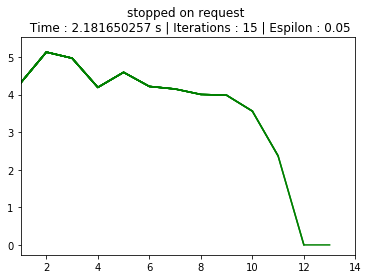

In [17]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 1 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


# Customizing the learning algorithms

## 1. Learn a tree ?

In [18]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
bn2

(gum::BayesNet<double>@0x8c3ad20) BN{nodes: 8, arcs: 7, domainSize: 256, parameters: 30, compression ratio: 88% }

## 2. with prior structural knowledge

In [19]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc("smoking?","lung_cancer?") # smoking->lung_cancer
# I know that visit to Asia may change the risk of tuberculosis
learner.addMandatoryArc("visit_to_Asia?","tuberculosis?") # visit_to_Asia->tuberculosis

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

{'klPQ': 5.05894829742651e-05,
 'errorPQ': 0,
 'klQP': 4.707576216334545e-05,
 'errorQP': 128,
 'hellinger': 0.0042324758267706965,
 'bhattacharya': 8.951324009049364e-06}

## 3. changing the scores

By default, a BDEU score is used. But it can be changed.

In [20]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

## 4. Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [21]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

And then we refine with tabuList

In [22]:
learner=gum.BNLearner(os.path.join("out","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
#learner.setMaxNbDecreasingChanges(2)

bn3=learner.learnBN()
kl=gum.BruteForceKL(bn,bn3)
gnb.sideBySide(bn3,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

# Impact of the size of the database for the learning

In [23]:
!head out/sample_asia.csv

tuberculosis?,bronchitis?,tuberculos_or_cancer?,visit_to_Asia?,positive_XraY?,smoking?,lung_cancer?,dyspnoea?
1,1,1,1,1,0,1,1
1,1,1,1,0,1,1,1
1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,0
1,1,1,1,1,0,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1
1,0,1,1,1,1,1,0


In [24]:
import IPython.display
rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]


401
501
701
1001
2001
5001
10001
50001
75001
100001
150001
175001
200001
300001
500000


3.6644376036182996e-05


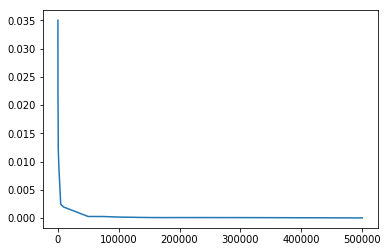

In [25]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    oslike.rm(os.path.join("out",'extract_asia.csv'))
    oslike.head(os.path.join("out","sample_asia.csv"),n,os.path.join("out","extract_asia.csv"))
    oslike.wc_l(os.path.join("out","extract_asia.csv"))
    learner=gum.BNLearner(os.path.join("out","extract_asia.csv"),bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    bn2=learner.learnBN()
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3",format="svg")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])

401
501
701
1001
2001
5001
10001
50001
75001
100001
150001
175001
200001
300001
500000


3.961029466817805e-05


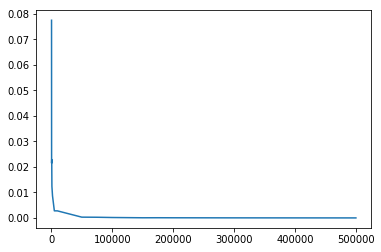

In [26]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    oslike.rm(os.path.join("out","extract_asia.csv"))
    oslike.head(os.path.join("out","sample_asia.csv"),n,os.path.join("out","extract_asia.csv"))
    oslike.wc_l(os.path.join("out","extract_asia.csv"))
    learner=gum.BNLearner(os.path.join("out","extract_asia.csv"),bn) #using bn as template for variables
    learner.useLocalSearchWithTabuList()
    bn2=learner.learnBN()
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    bn2.setProperty("name","BN(%{0})".format(i))
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3",format="svg")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])